# Text -> binary -> codeword -> binary -> text

In [1]:
import txt_binary as tb
import BinaryToCodeword as b2c
import CodewordToBinary as c2b

In [2]:
#####################
###### TO KEEP ######
#####################

txt = "Les#é!^ ?''& %* ç a"

bits = tb.text_to_bits(txt)
#print("bits:",bits)

codeword = b2c.f(bits)
#print("codeword:", codeword)

bits2 = c2b.f(codeword)
#print("bits2:",bits2)

res = tb.text_from_bits(bits2)

print(res)

#####################
###### TO KEEP ######
#####################

Les#é!^ ?''& %* ç a


---
# Mathematical part to study $\Psi$(t)

In [3]:
import numpy as np
#np.seterr(divide='ignore', invalid='ignore')
from matplotlib import pyplot as plt
%matplotlib inline

To observe what we have for our $\psi$ function.

In [4]:
beta = 1/2.0
T_psi = 1/1300 # we want it small (try to play with and see) but be careful aliasing when we add 4 modulated version of it
print("The frequency-band will have a width of:",1/T_psi,"Hz until 1/2T (see p. 171)")

def psi(t):
    c = 1.0 - np.square(4.0 * beta * t / T_psi)
    
    temp_error = np.geterr()
    np.seterr(divide='ignore', invalid='ignore')
    res = np.where(np.abs(c) <= 1E-2,
                   (beta / (np.pi * np.sqrt(2 * T_psi)))
                   * ((np.pi + 2) * np.sin(np.pi / (4 * beta))
                      +(np.pi - 2) * np.cos(np.pi / (4 * beta))),
                   
                   (4.0 * beta)/(np.pi * np.sqrt(T_psi))
                   * (np.cos((1.0 + beta) * np.pi * t / T_psi)
                      + ((1.0 - beta) * np.pi) / (4.0 * beta) * np.sinc((1.0 - beta) * t / T_psi))
                   / c
                   )
    np.seterr(divide='warn', invalid='warn')
    
    return res

The frequency-band will have a width of: 1300.0 Hz until 1/2T (see p. 171)


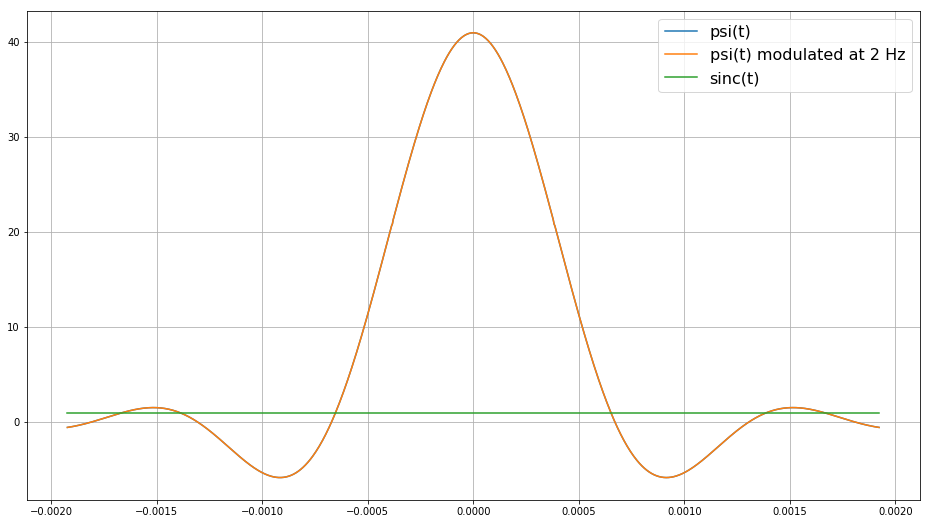

In [5]:
t = np.linspace(start=-5*T_psi/(4*beta), stop=5*T_psi/(4*beta), num = 1000)
freq = 2

plt.figure(figsize=(16,9))
plt.plot(t, psi(t), t, psi(t)*np.cos(2*np.pi*freq*t), t, np.sinc(t))
plt.legend(["psi(t)", "psi(t) modulated at " + str(freq) + " Hz", "sinc(t)"], fontsize=16)
plt.grid()
plt.show()

If *T_psi* really small, then the blue curve and the yellow one are superposed.

number of sample needed: 3603


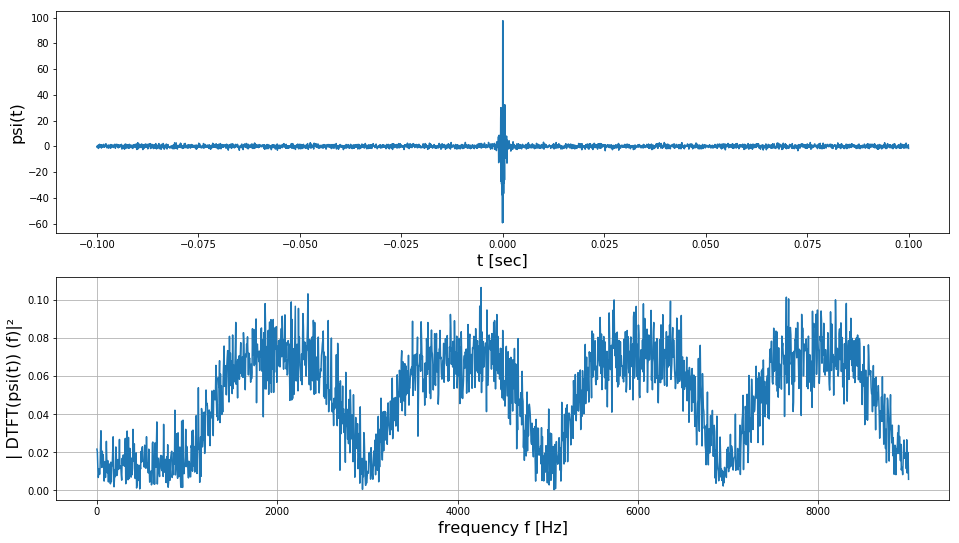

In [25]:
#############################################
###### https://plot.ly/matplotlib/fft/ ######
#############################################

ff = 2000 # frequency of the signal in Hz
Fs = 8.0 * ff + (1.55/T_psi)  # sampling rate /!\ Choose a factor which respect the sampling theorem (>=2*4 + a little bit to avoid aliasing in freq domain)
Ts = 1.0/Fs # sampling interval
time_interval = 0.1
t = np.arange(-time_interval, time_interval, Ts) # time vector

amplitude = 1
y_base = amplitude * psi(t)

# Modulate our signal
y = y_base * np.cos(2*np.pi*ff*t) + y_base * np.cos(2*2*np.pi*ff*t) + y_base * np.cos(3*2*np.pi*ff*t) + y_base * np.cos(4*2*np.pi*ff*t)

# Add gaussian noise
n = len(y) # length of the signal
print("number of sample needed:",n)
y = y + np.random.normal(0, 1, n)

k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n // 2)] # one side frequency range (7 = 3*2+1 ==> 7//2 = 6//2 = 3)

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n // 2)]


# Plot
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(t,y)
plt.xlabel("t [sec]",fontsize=16)
plt.ylabel("psi(t)",fontsize=16)
plt.subplot(212)
plt.plot(frq, np.abs(Y))
plt.xlabel("frequency f [Hz]",fontsize=16)
plt.ylabel("| DTFT(psi(t)) (f)|²",fontsize=16)
plt.grid()
plt.show()

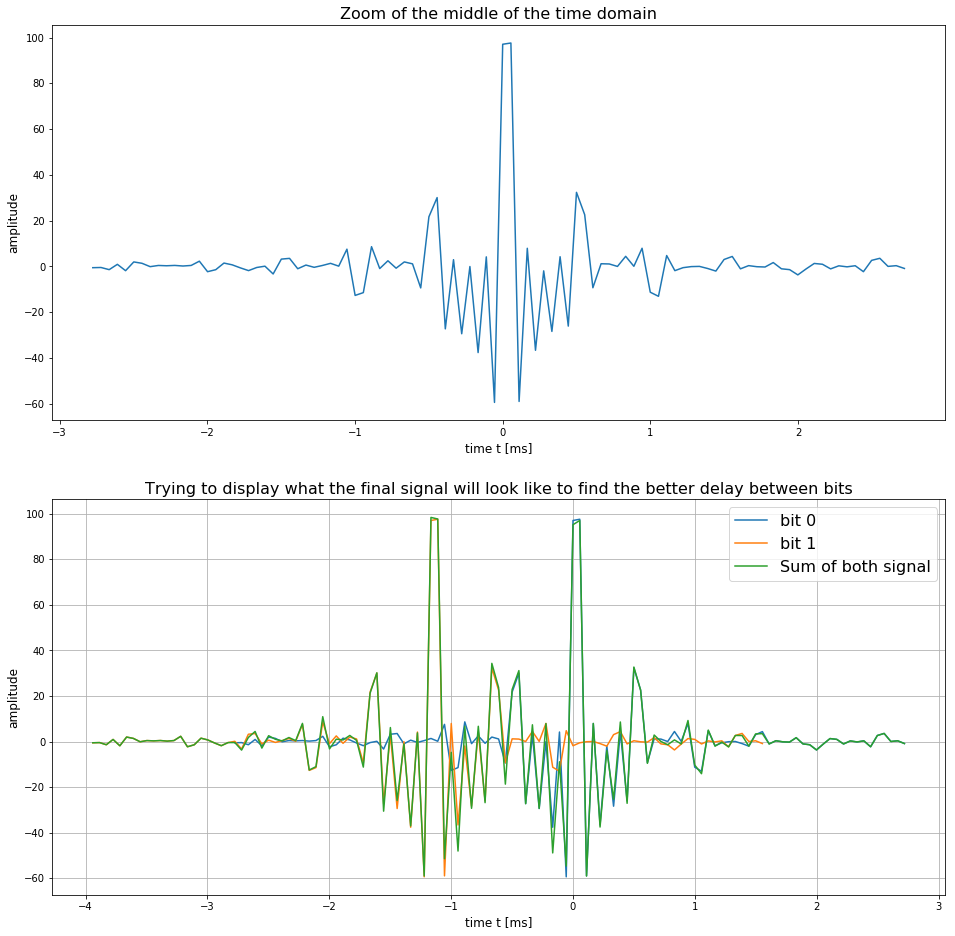

In [74]:
sample_interval = 50
test = y[len(y)//2-sample_interval:len(y)//2+sample_interval]

delay = 21 # number of sample that we wait before sending the second bit

sum = [0 for i in range(len(test) + delay)]
for i in range(len(sum)):
    j = i-delay
    if (i < len(test)):
        sum[i] += test[i]
    if (j >= 0):
        sum[i] += test[j]

plt.figure(figsize=(16,16))
plt.grid(b=True)
plt.subplot(211)
plt.plot([(i-sample_interval)*1E3*Ts for i in range(len(test))], test)
plt.title("Zoom of the middle of the time domain",fontsize=16)
plt.xlabel("time t [ms]", fontsize=12)
plt.ylabel("amplitude",fontsize=12)
plt.subplot(212)
plt.plot([(i-sample_interval)*1E3*Ts for i in range(len(test))], test,
         [(i-delay-sample_interval)*1E3*Ts for i in range(len(test))], test,
         [(i-delay-sample_interval)*1E3*Ts for i in range(len(sum))], sum)
plt.title("Trying to display what the final signal will look like to find the better delay between bits",fontsize=16)
plt.xlabel("time t [ms]", fontsize=12)
plt.ylabel("amplitude",fontsize=12)
plt.legend(["bit 0", "bit 1", "Sum of both signal"], fontsize=16)
plt.grid()
plt.show()

In [82]:
print("Estimation of how many addition are needed to compute the signal that will be send to the server [#additions]:", n*160)

print("\nUSING AMPLITUDE THRESHOLD:")
est_time_shift = 2*(time_interval-np.argwhere(np.abs(y) >= 10*amplitude)[0,0]*Ts) # Estimated time shift between 2 bits
print(est_time_shift/2.*1E3)
print("Estimation of the timeshift needed between two bits [ms]:",est_time_shift*1E3)
print("Estimation of how long the *.wav that we will send to the server will be [s]:",160*8*est_time_shift)

print("\nUSING GRAPHICAL APPROXIMATION:")
est_time_shift = delay*Ts
print(est_time_shift/2.*1E3)
print("Estimation of the timeshift needed between two bits [ms]:",est_time_shift*1E3)
print("Estimation of how long the *.wav that we will send to the server will be [s]:",160*8*est_time_shift)

print("\nNot interesting tests:")
print(160*8*1E-3)
print(1.02692200943659/Ts*1E-3)

Estimation of how many addition are needed to compute the signal that will be send to the server [#additions]: 576480

USING AMPLITUDE THRESHOLD:
1.02692200943659
Estimation of the timeshift needed between two bits [ms]: 2.05384401887318
Estimation of how long the *.wav that we will send to the server will be [s]: 2.6289203441576703

USING GRAPHICAL APPROXIMATION:
0.5828476269775188
Estimation of the timeshift needed between two bits [ms]: 1.1656952539550376
Estimation of how long the *.wav that we will send to the server will be [s]: 1.492089925062448

Not interesting tests:
1.28
18.50000000000017


---
# TODOs

* Compute signal to noise ratio to estimate mathematically the amplification needed to obtain a good SNR

---
# Not important tests

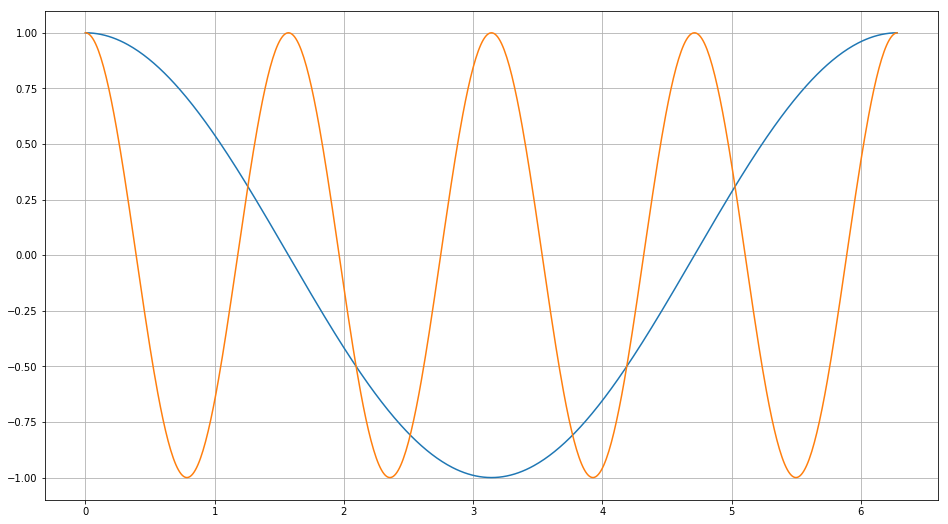

In [9]:
# Some tests to observe differents things (NOT SO IMPORTANT)
n = np.arange(0,2*np.pi,0.01)

plt.figure(figsize=(16,9))
plt.plot(n, np.cos(n), n,np.cos(4*n))
plt.grid()
plt.show()

In [10]:
#A simple loop to observe the time needed to do a certain number of additions
counter = 0
for i in range(11529600):
    counter+=1
print(counter)

11529600
